# Higgs ML Neural Net 

Data taken from http://opendata.cern.ch/record/328?ln=en

In [1]:
%%bash
#jupyter nbextension enable --py widgetsnbextension

In [2]:
import keras

Using TensorFlow backend.


In [3]:
import pandas as pd 
import csv 
import numpy as np

In [4]:
import tensorflow

### Input File

Download the csv file and convert into a dataframe. 

In [5]:
df = pd.read_csv("/Users/up/Downloads/atlas-higgs-challenge-2014-v2.csv")
df.head() #Take a look at the first 5 entries

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.00,-999.000,46.226,0.681042,b,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0.715742,b,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,1.660654,b,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.904263,b,t,6.245333


# A little background on the *Background*
Only three background processes were kept for the Challenge to simplify things. From the documentation these are: 
- the decay of the Z boson (with a mass of 91.2 GeV) into two taus
- events with a pair of top quarks, which can have a lepton and a hadronic tau among their decay
- the decay of the W boson, where one electron or muon and a hadronic tau can appear simultaneously only through imperfections of the particle identification procedure. 

See [page](http://opendata.cern.ch/record/328) for more details. 

## Pre-processing
First we're going to have to remove some columns that we won't use as input to the classifier. You can read more about it in the pdf documentation. We'll also have to do two things to facilitate the learning process:
replace the label signal = 's' and background = 'b' with 0s nd 1s, respectively and,
normalize the data so that learning would be faster.


In [6]:
#Replace signal and background labels with 1s and 0s
df['Label'] = df['Label'].map({'s':0 , 'b':1})
df.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,0,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.00,-999.000,46.226,0.681042,1,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0.715742,1,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,1.660654,1,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.904263,1,t,6.245333


In [7]:
exclude = ['EventId','Events', 'Weight', 'Label', 'KaggleSet', 'KaggleWeight']
trainData = df.loc[:, df.columns.difference(exclude)] 

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
trainData[trainData.columns] = scaler.fit_transform(trainData[trainData.columns])
trainData.head()

,DER_deltaeta_jet_jet,DER_deltar_tau_lep,DER_lep_eta_centrality,DER_mass_MMC,DER_mass_jet_jet,DER_mass_transverse_met_lep,DER_mass_vis,DER_met_phi_centrality,DER_prodeta_jet_jet,DER_pt_h,...,PRI_jet_subleading_pt,PRI_lep_eta,PRI_lep_phi,PRI_lep_pt,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_tau_eta,PRI_tau_phi,PRI_tau_pt
0,1.558181,0.883789,1.560901,0.461169,1.100465,0.067902,0.411171,1.275526,1.569166,-0.471040,...,1.535972,1.812996,-1.357205,0.222812,-0.764108,-0.148047,0.384999,0.847675,0.217038,-0.270193
1,-0.640420,1.407561,-0.640422,0.516490,-0.605427,0.551613,0.544430,1.290599,-0.640416,-0.153024,...,-0.639996,0.411374,0.029497,-0.441436,0.093841,-1.052222,-0.357703,1.689860,-1.650719,0.147838
2,-0.640420,0.991361,-0.640422,-2.339666,-0.605427,3.191741,1.104226,1.290599,-0.640416,-0.350321,...,-0.639996,-0.738715,0.552334,3.374379,0.388615,-1.201171,0.398254,-0.571348,-1.145236,-0.291772
3,-0.640420,1.198820,-0.640422,0.474552,-0.605427,0.909146,-0.004868,-0.969427,-0.640416,-0.905753,...,-0.639996,-0.397802,-1.735147,0.299363,-0.325348,0.037863,-0.976581,-1.354201,0.012752,-0.715643
4,-0.640420,1.942858,-0.640422,0.553245,-0.605427,-0.914048,1.322348,-1.053163,-0.640416,-0.653576,...,-0.639996,0.646296,0.837167,-0.764076,-1.198037,-0.475735,-1.236256,-1.800839,-1.221223,-0.467660


In [65]:
#df.info()

## Splitting the dataset into training and validation sets
We then split our dataset into training and validation sets. A good [rule of thumb](https://stackoverflow.com/questions/13610074/is-there-a-rule-of-thumb-for-how-to-divide-a-dataset-into-training-and-validatio) is to split into 80/20 training and testing (or a cross-validation) set. However a test set with 100000 would be good enough. We'll use scikit-learn's train_test_split function to do this. 

Recall that the **trainData** DataFrame has already excluded the labels and other non-inputs to the classifier. It contains all the other features that will help us discriminate between signal and background. We'll put in as first argument, trainData into the **train_test_split** function. The second argument would be the label for each instance. This tells whether the event is signal (0) or background (1). 

In [9]:
from sklearn.cross_validation import train_test_split
rawXtrain, rawXcv, ytrain, ycv = train_test_split(trainData, df.Label, random_state=1, test_size=100000)

# For Keras: recast as matrix
Xtrain = rawXtrain.as_matrix()
Xcv = rawXcv.as_matrix()
print ("Input shape to model:",Xtrain.shape)

/Users/up/miniconda3/envs/mlhep3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Input shape to model: (718238, 30)


Let's see if our dataset split properly. There should be 100,000 instances for our testing set. The training set with the labels will be sort of *memorized* by our classifier and will be used to classify new and unfamiliar instances into signal and background. 

In [10]:
# Print the shapes of both sets.
print(rawXtrain.shape)
print(rawXcv.shape)
print(ytrain.shape)
print(ycv.shape)

(718238, 30)
(100000, 30)
(718238,)
(100000,)


In [ ]:
#ycv

# Defining the model
We use a 3-hidden layer fully-connected network: input->FC:64->FC:32->FC:1->output. Deeper and shallower networks were attempted but the below 3-layer network proved to work best. Other particulars:  
 - Sigmoid activation peformed better than the popular relu   
 - Unnecessary to apply L2 regularization   
 - Truncated Normal weight initializations work best   
 - Applied dropout



In [11]:
# Import some keras deps
from keras.models import Sequential
from keras.layers import Dense, Dropout
#from keras.initializations import glorot_normal
from keras import initializers

# Compile simple Keras model: fully-connected, multi-layer
model = Sequential()
model.add(Dense(64, activation='sigmoid', input_shape=(Xtrain.shape[1],), init='glorot_normal'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='sigmoid', init='glorot_normal'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid', init='glorot_normal'))

model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/Users/up/miniconda3/envs/mlhep3/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, activation="sigmoid", kernel_initializer="glorot_normal", input_shape=(30,))`
  if __name__ == '__main__':
/Users/up/miniconda3/envs/mlhep3/lib/python3.5/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="sigmoid", kernel_initializer="glorot_normal")`
  # This is added back by InteractiveShellApp.init_path()
/Users/up/miniconda3/envs/mlhep3/lib/python3.5/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="glorot_normal")`
  del sys.path[0]


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1984      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.fit(Xtrain, ytrain, epochs=10, verbose=1)

Epoch 1/10
718238/718238 [==============================] - 127s - loss: 0.4385 - acc: 0.7933   
Epoch 2/10
718238/718238 [==============================] - 247s - loss: 0.3988 - acc: 0.8179   
Epoch 3/10
718238/718238 [==============================] - 308s - loss: 0.3920 - acc: 0.8219   
Epoch 4/10
718238/718238 [==============================] - 435s - loss: 0.3887 - acc: 0.8236   - ETA: 1s - loss
Epoch 5/10
718238/718238 [==============================] - 339s - loss: 0.3865 - acc: 0.8250   
Epoch 6/10
718238/718238 [==============================] - 295s - loss: 0.3848 - acc: 0.8261   
Epoch 7/10
718238/718238 [==============================] - 336s - loss: 0.3836 - acc: 0.8267   
Epoch 8/10
718238/718238 [==============================] - 335s - loss: 0.3824 - acc: 0.8267   
Epoch 9/10
718238/718238 [==============================] - 297s - loss: 0.3817 - acc: 0.8277   
Epoch 10/10
718238/718238 [==============================] - 306s - loss: 0.3809 - acc: 0.8282   


# Evaluating on CV
Below we present standard metrics for evaluating the trained model on the CV set.

# Confusion matrix

A confusion matrix, in this case for a binary classifier, is a way to tabulate the misclassified items.
From the matrix below, we know that there are two possible classes, signal = 0 and background = 1.

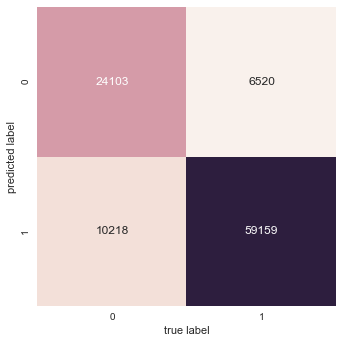

In [13]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()

testPrediction = model.predict_classes(Xcv, verbose=0)
testPrediction = testPrediction.flatten()

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ycv, testPrediction)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
#                xticklabels=testLabels, yticklabels=testLabels)
plt.xlabel('true label')
plt.ylabel('predicted label');

CV ROC AUC: 0.903336314862


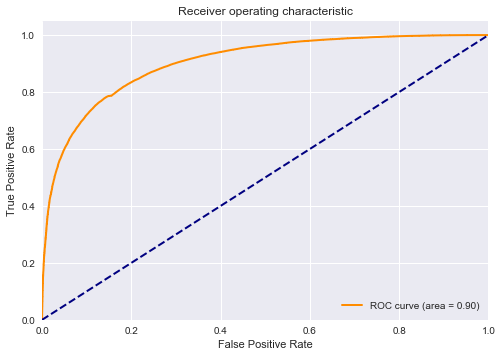

In [15]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC AUC
y_score = model.predict_proba(Xcv, verbose=0)
fpr, tpr, thresholds = roc_curve(ycv,y_score[:,0])
roc_auc = auc(fpr,tpr) 
print ("CV ROC AUC:",roc_auc)

# Plot ROC
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()